In [1]:
!pip install keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


# Utils

In [18]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from typing import List

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
class Pipeline:
    def __init__(self, data: pd.DataFrame) -> None:
        self.data = data
        self.combined_df: pd.DataFrame = None

    def process(self) -> pd.DataFrame:
        timestamps = self.data["timestamp"]
        columns = [
            "light_air",
            "moisture_ground",
            "dht_air_humidity",
            "dht_air_temperature",
            "dht_ground_humidity",
            "dht_ground_temperature",
        ]
        indexes = self.__fix_missing_vaues(timestamps)
        dataframe = self.__add_missing_values(indexes)
        dataframe = self.__detrend(dataframe, columns, 30)
        dataframe = self.__scale(dataframe, columns)

        return dataframe

    def __fix_missing_vaues(self, timestamps: np.ndarray):
        """
        Return array of indexes where values are missing between that index and next.
        """
        t = int(timestamps[0])
        c = 0
        indexes = []
        for i, timestamp in enumerate(timestamps[1:]):
            diff = int(timestamp) - t
            t = int(timestamp)

            # missing data from sensors
            # at least one timestamp is missing
            if diff >= 60:
                indexes.append(i)
                c += diff // 30

        print(f"[+] Total missing values: {c}")

        return indexes

    def __add_missing_values(self, indexes) -> pd.DataFrame:
        """
        Creates a new pandas dataframe with the new values added.
        """

        # Assuming indexes and timestamps are defined somewhere in your code
        cols = self.data.columns
        timestamps = self.data["timestamp"]
        new_data = []

        for index in indexes:
            diff = timestamps[index + 1] - timestamps[index]
            n_values = diff // 30

            if n_values > 0:
                # nan_values = np.full((n_values, len(cols)), np.nan)
                for i in range(n_values):
                    value = [np.nan] * len(cols)
                    value[0] = timestamps[index] + (i + 1) * 30
                    new_data.append(value)

        new_data_df = pd.DataFrame(new_data, columns=cols)
        combined_df = pd.concat([self.data, new_data_df], ignore_index=True)

        combined_df.sort_values("timestamp", inplace=True)
        combined_df.reset_index(drop=True, inplace=True)

        # resolve NaN values
        for col in combined_df.columns:
            combined_df[col] = combined_df[col].interpolate()

        # change moisture for mean of moisture
        # this is because there was a problem with the sensor
        # and the data is inconsistent
        moving_avg = combined_df["moisture_ground"].rolling(window=30).mean()
        combined_df.drop(columns=["moisture_ground"])
        combined_df["moisture_ground"] = moving_avg

        return combined_df

    def __detrend(
        self, data: pd.DataFrame, columns: List[str], window_size: int
    ) -> pd.DataFrame:
        """
        Detrend columns use wants.
        """
        detrended_df = pd.DataFrame()
        for col in columns:
            moving_avg = data[col].rolling(window=window_size).mean()
            detrended_ts = data[col] - moving_avg
            detrended_df[col] = detrended_ts

        detrended_df["timestamp"] = data["timestamp"]
        # get rid of first 30 values because no trend can be calculated thus is filled with NaN values
        detrended_df = detrended_df.dropna()

        return detrended_df

    def __scale(self, data: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
        """
        scale (0, 1)
        """
        scaled_df = pd.DataFrame()
        for col in columns:
            # scaling values
            min_val = data[f"{col}"].min()
            max_val = data[f"{col}"].max()
            scaled_series = (data[f"{col}"] - min_val) / (max_val - min_val)
            scaled_df[col] = scaled_series

        scaled_df["timestamp"] = data["timestamp"]

        return scaled_df

In [4]:
class Ensemble(BaseEstimator):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=0)

    def evaluate(self, X, y, metric=mean_squared_error):
        preds = self.predict(X)
        return metric(y, preds)


In [19]:
def plot_ensemble_predictions(ensemble_model, X_test, y_test, target):
    """
    Generates a plot of ensemble model predictions compared to actual values.

    Parameters:
    ensemble_model (model object): The ensemble model used for predictions.
    X_test (DataFrame or array-like): The input data for which predictions will be made.
    y_test (DataFrame, Series, or array-like): The actual target values.
    target (str): The name of the target (used for the Y-axis label).

    Returns:
    None
    """
    ensemble_preds = ensemble_model.predict(X_test)

    plt.figure(figsize=(14, 7))
    plt.plot(y_test.values, label='Actual', color='blue')
    plt.plot(ensemble_preds, label='Ensemble Prediction', color='red', linestyle='--')

    # plt settings
    plt.legend()
    plt.title('Actual vs Ensemble Prediction')
    plt.xlabel('Time')
    plt.ylabel(target)

    mse = ensemble_model.evaluate(X_test, y_test)
    print(f'Ensemble Model MSE: {mse}')
    plt.show()

# Setup

In [6]:
test_url = "https://gist.githubusercontent.com/w-dan/5dd47369b014640689e0eeb203e718b8/raw/d973b2a9f2f4f708c6fe644e22d72d36cfd05940/split_test.csv"
train_url = "https://gist.githubusercontent.com/w-dan/5dd47369b014640689e0eeb203e718b8/raw/d973b2a9f2f4f708c6fe644e22d72d36cfd05940/split_train.csv"

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

In [7]:
train_df.shape

(9000, 8)

In [8]:
pipe_train_df = Pipeline(train_df)
pipe_test_df = Pipeline(test_df)

In [9]:
train_df = pipe_train_df.process()
test_df = pipe_test_df.process()

y_train = train_df['moisture_ground']
X_train = train_df.drop('moisture_ground', axis=1)
y_test = test_df['moisture_ground']
X_test = test_df.drop('moisture_ground', axis=1)

[+] Total missing values: 483
[+] Total missing values: 169


In [10]:
train_df.shape

(9425, 7)

# Ensemble class

In [11]:
target = "Ground Moisture"

In [12]:
models = [
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    SVR(kernel='rbf')
]

# create and evaluate
ensemble_model = Ensemble(models)
ensemble_model.fit(X_train, y_train)

In [13]:
# evaluating
mse = ensemble_model.evaluate(X_test, y_test)
print(f'Ensemble Model MSE: {mse}')

Ensemble Model MSE: 0.02334128185154848


Ensemble Model MSE: 0.02412772139419421


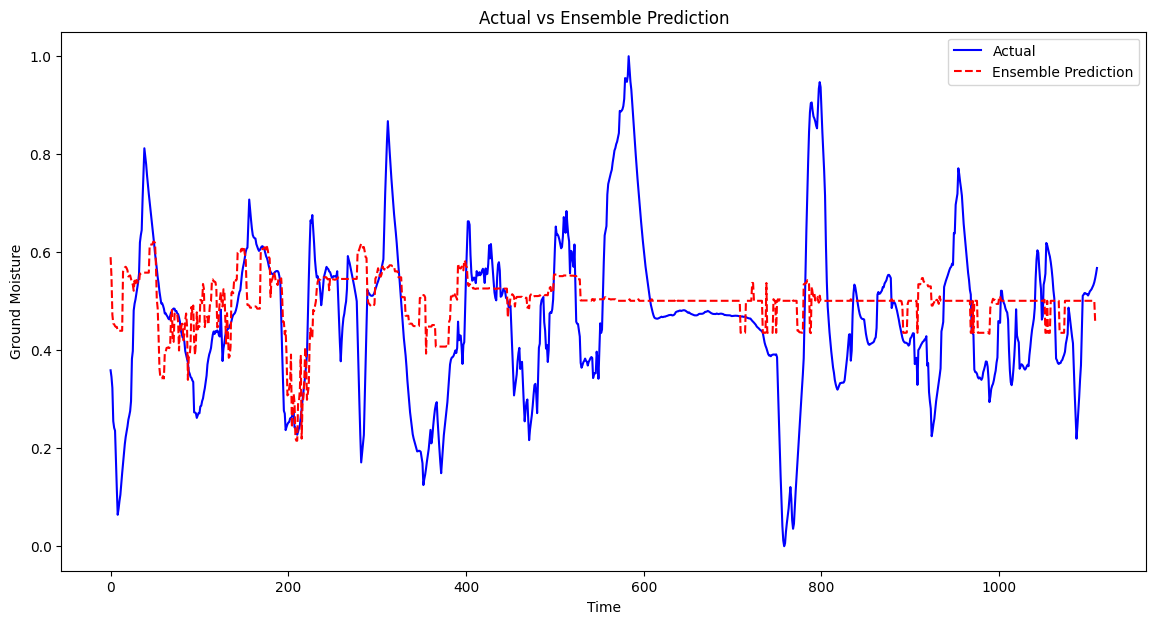

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# predict and plot
plot_ensemble_predictions(ensemble_model, X_test, y_test, target)

# Test Case 1: Combining RandomForest and GradientBoosting

Ensemble Model MSE: 0.02412772139419421


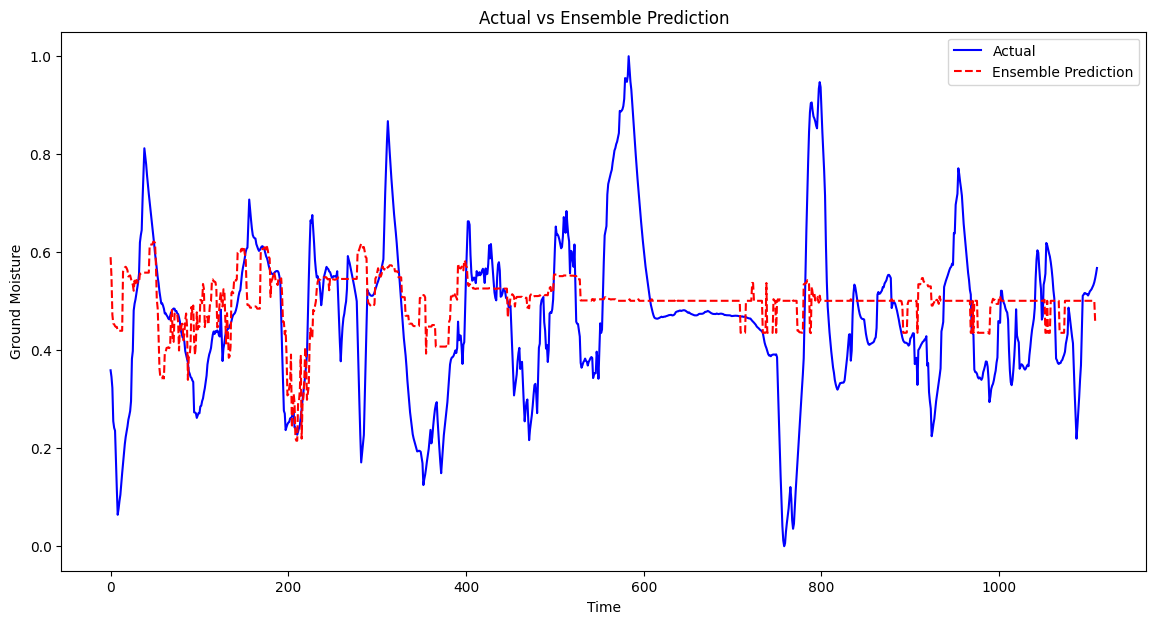

In [24]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# ensemble with given models
ensemble_model = Ensemble([rf_model, gb_model])
ensemble_model.fit(X_train, y_train)

plot_ensemble_predictions(ensemble_model, X_test, y_test, target)

# Test Case 2: Adding SVR to the Ensemble

Ensemble Model MSE: 0.02334128185154848


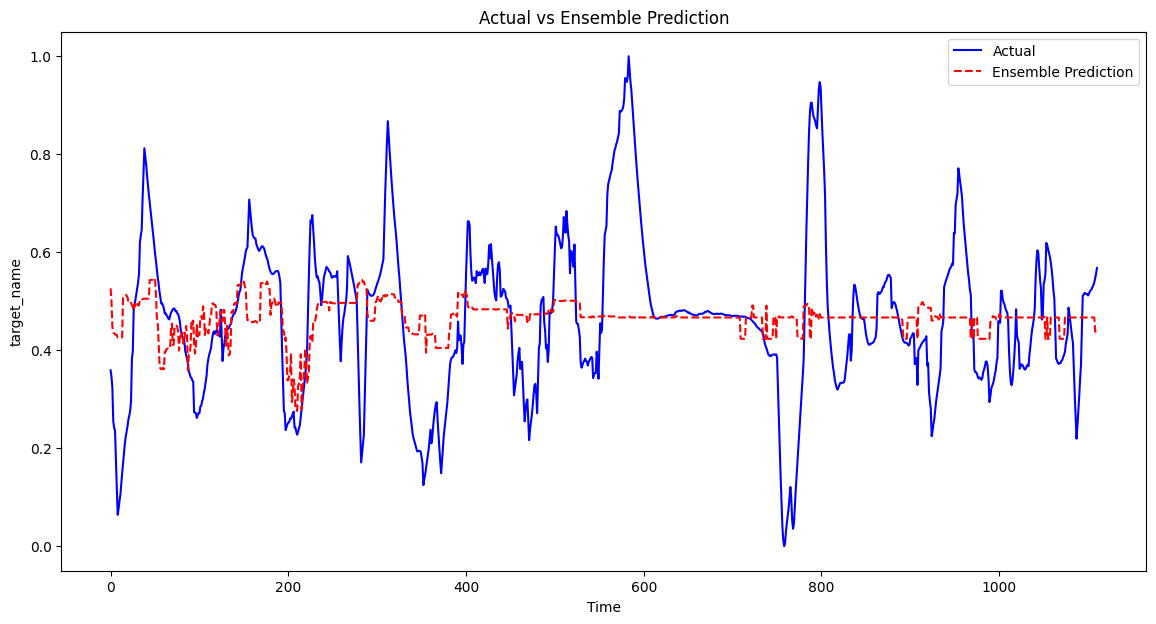

In [25]:
svr_model = SVR(kernel='rbf')

ensemble_model = Ensemble([rf_model, gb_model, svr_model])
ensemble_model.fit(X_train, y_train)

plot_ensemble_predictions(ensemble_model, X_test, y_test, 'target_name')

# Test Case 3: Ensemble of Three GradientBoosting Models with Different Parameters


It is possible that many of the models we tested were excessively complex compared to the data they are fitting to. To solve this, we will utilize three gradient boosting regressors:

- 5 estimators, not very sensitive to peaks
- 20 estimators, more sensitive
- 30 estimators, will more likely adapt to smaller perturbations

And we will average their predictions to achieve an equilibrium where the final predictions show no signs of overfitting, that is:

- Adjusting perfectly to small perturbations and noise
- Excessive responsiveness to peaks

Ensemble Model MSE: 0.012271986060253584


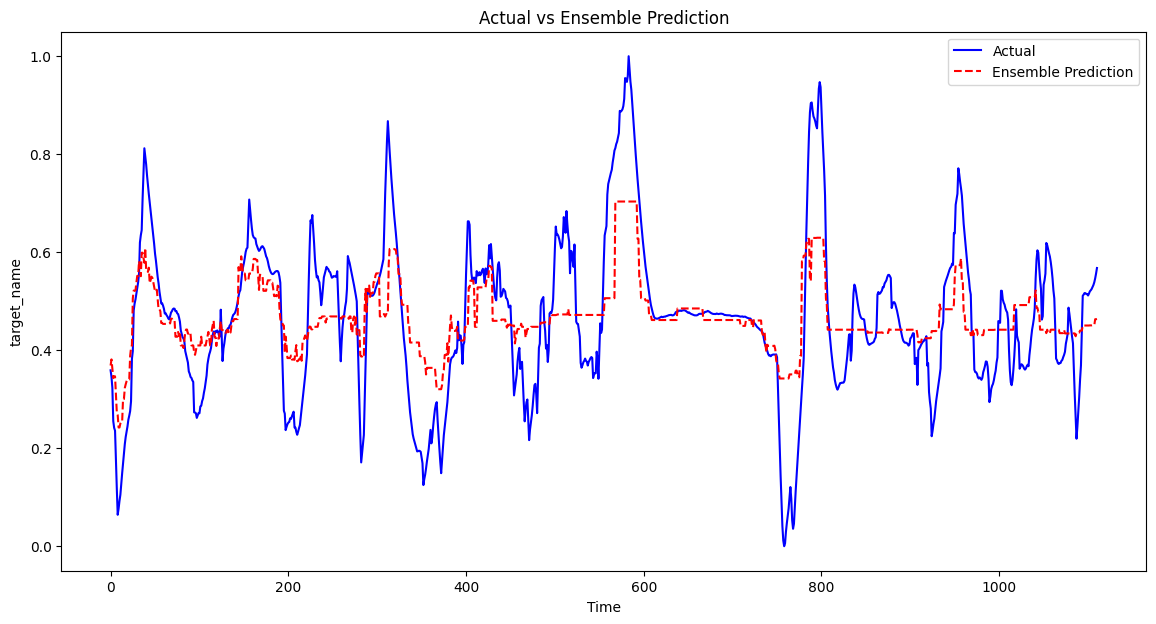

In [30]:
gb_model1 = GradientBoostingRegressor(n_estimators=5, random_state=42)
gb_model2 = GradientBoostingRegressor(n_estimators=20, random_state=42)
gb_model3 = GradientBoostingRegressor(n_estimators=30, random_state=42)

ensemble_model = Ensemble([gb_model1, gb_model2, gb_model3])

ensemble_model.fit(X_test, y_test)

plot_ensemble_predictions(ensemble_model, X_test, y_test, 'target_name')

As the lower MSE suggests, the ensemble achieved a much more accurate fit. It proves to be a robust fit, since it shows barely any responsiveness to nose (between 400 and 600 on the time axis), and it adjusts to peaks, although not fully.

Test for 5 estimators

Ensemble Model MSE: 0.018611748780492758


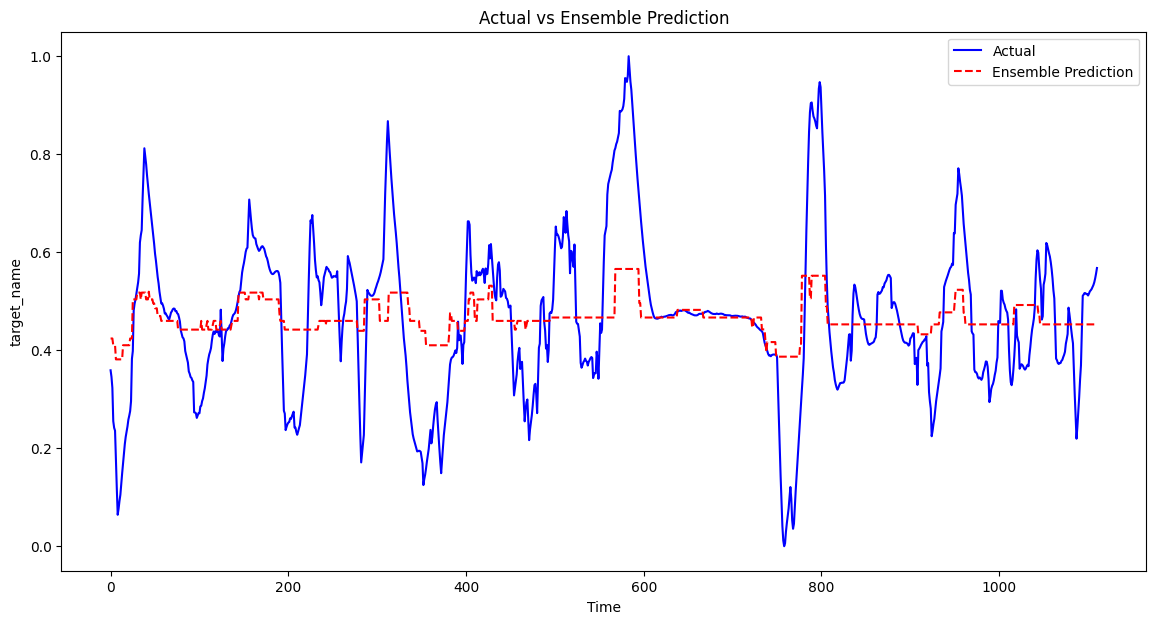

In [35]:
gb_model1 = GradientBoostingRegressor(n_estimators=5, random_state=42)
# gb_model2 = GradientBoostingRegressor(n_estimators=20, random_state=42)
# gb_model3 = GradientBoostingRegressor(n_estimators=30, random_state=42)

ensemble_model = Ensemble([gb_model1])

ensemble_model.fit(X_test, y_test)

plot_ensemble_predictions(ensemble_model, X_test, y_test, 'target_name')

Test for 20 estimators

Ensemble Model MSE: 0.01102604003022608


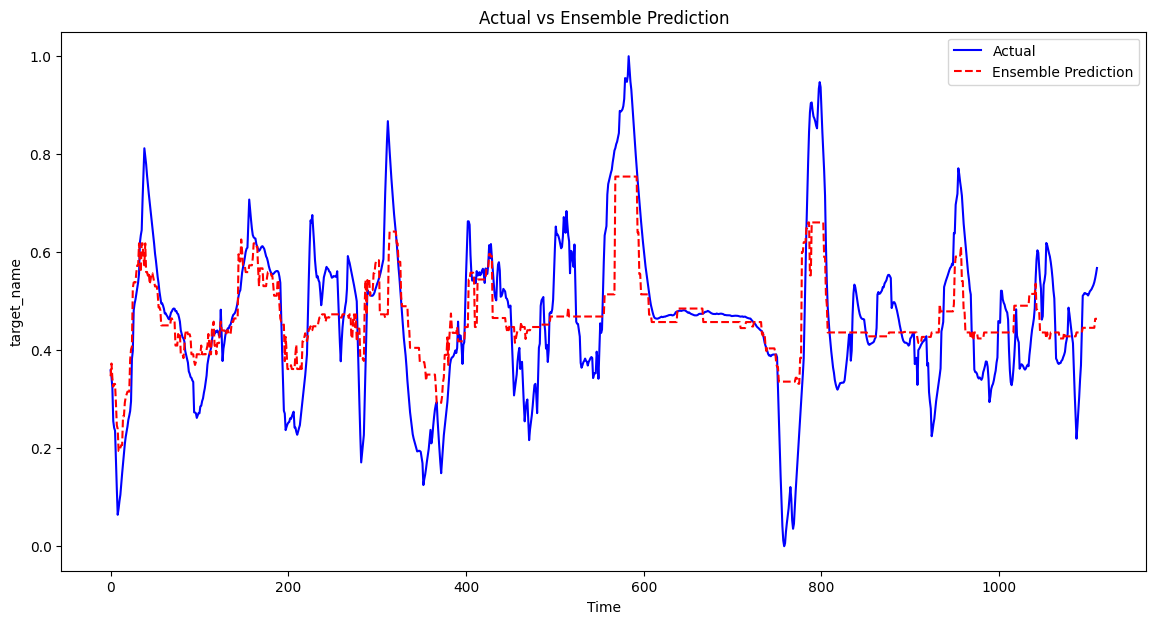

In [36]:
# gb_model1 = GradientBoostingRegressor(n_estimators=5, random_state=42)
gb_model2 = GradientBoostingRegressor(n_estimators=20, random_state=42)
# gb_model3 = GradientBoostingRegressor(n_estimators=30, random_state=42)

ensemble_model = Ensemble([gb_model2])

ensemble_model.fit(X_test, y_test)

plot_ensemble_predictions(ensemble_model, X_test, y_test, 'target_name')

20 estimators tends to fit excessively to noise, but responds properly to peaks.

Test for 30 estimators (overfitting)

Ensemble Model MSE: 0.009305753531666608


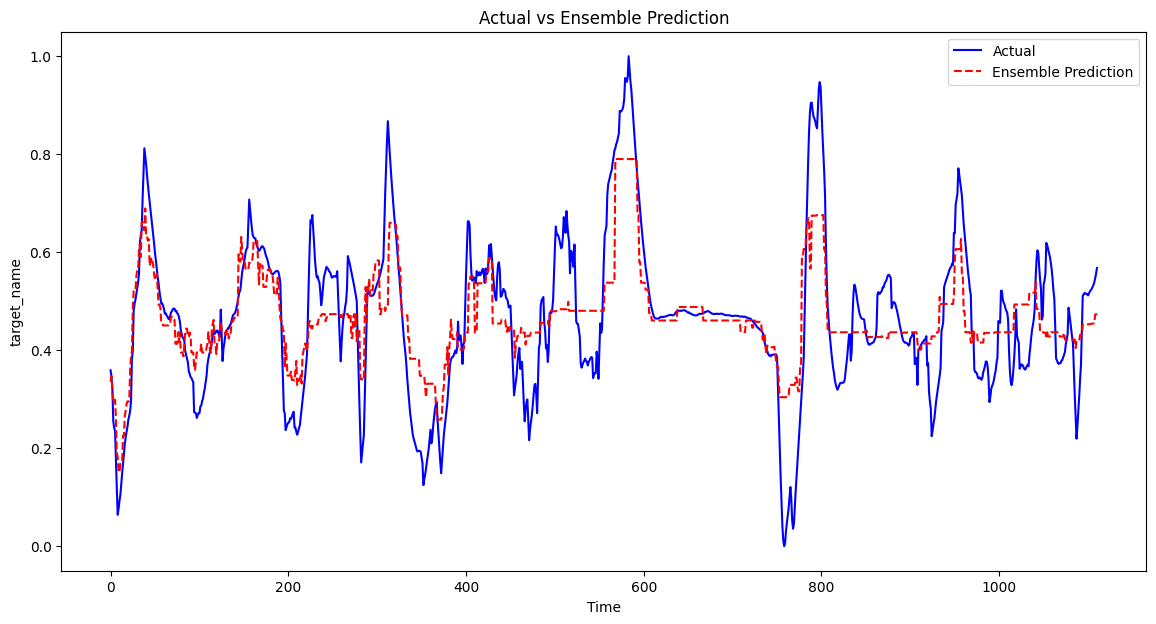

In [37]:
# gb_model1 = GradientBoostingRegressor(n_estimators=5, random_state=42)
# gb_model2 = GradientBoostingRegressor(n_estimators=20, random_state=42)
gb_model3 = GradientBoostingRegressor(n_estimators=30, random_state=42)

ensemble_model = Ensemble([gb_model3])

ensemble_model.fit(X_test, y_test)

plot_ensemble_predictions(ensemble_model, X_test, y_test, 'target_name')

The model, as depicted in the figure, fits to noise and slight perturbations, yielding a poor generalization capacity.

Test for the two lowest numbers of estimators:

Ensemble Model MSE: 0.014200906600206507


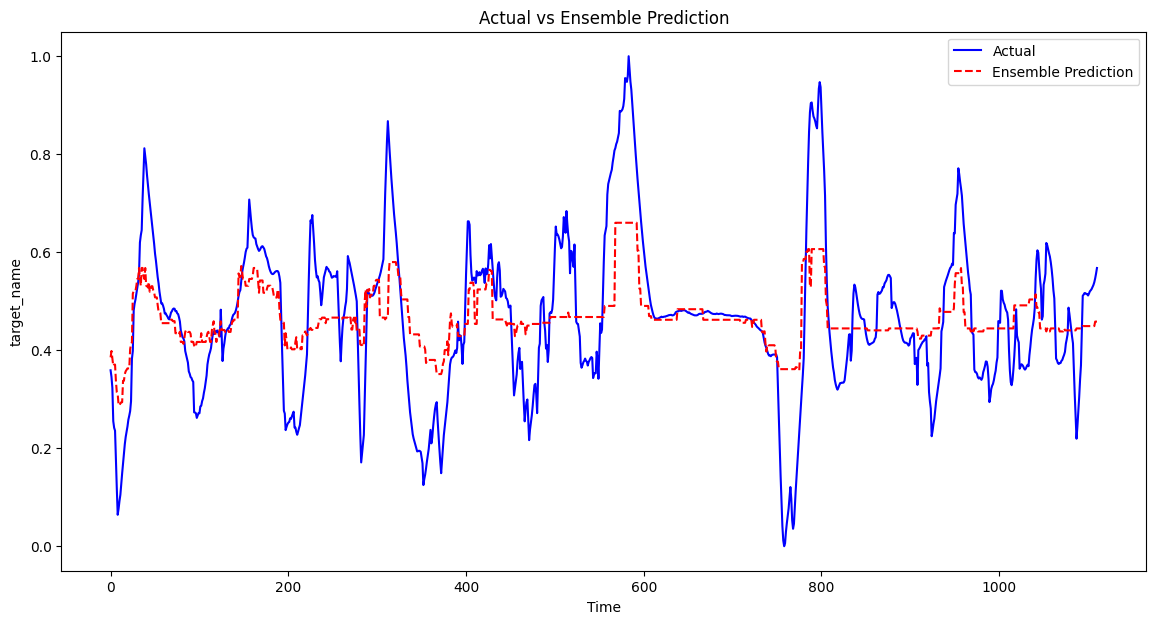

In [38]:
gb_model1 = GradientBoostingRegressor(n_estimators=5, random_state=42)
gb_model2 = GradientBoostingRegressor(n_estimators=20, random_state=42)
#gb_model3 = GradientBoostingRegressor(n_estimators=30, random_state=42)

ensemble_model = Ensemble([gb_model1, gb_model2])

ensemble_model.fit(X_test, y_test)

plot_ensemble_predictions(ensemble_model, X_test, y_test, 'target_name')

Combining 5 estimators and 20 estimators makes the model ignore noise, but it underfits slightly to peaks. Adding a third model with more estimators should make the average result more accurate.

The models fails to consistently adapt to higher perturbations. Therefore, it can be concluded that combining these three models yields better results in terms of generalization capabilities.

# Test Case 4: Ensemble with Two RandomForest and One SVR

Ensemble Model MSE: 0.025584150976641035


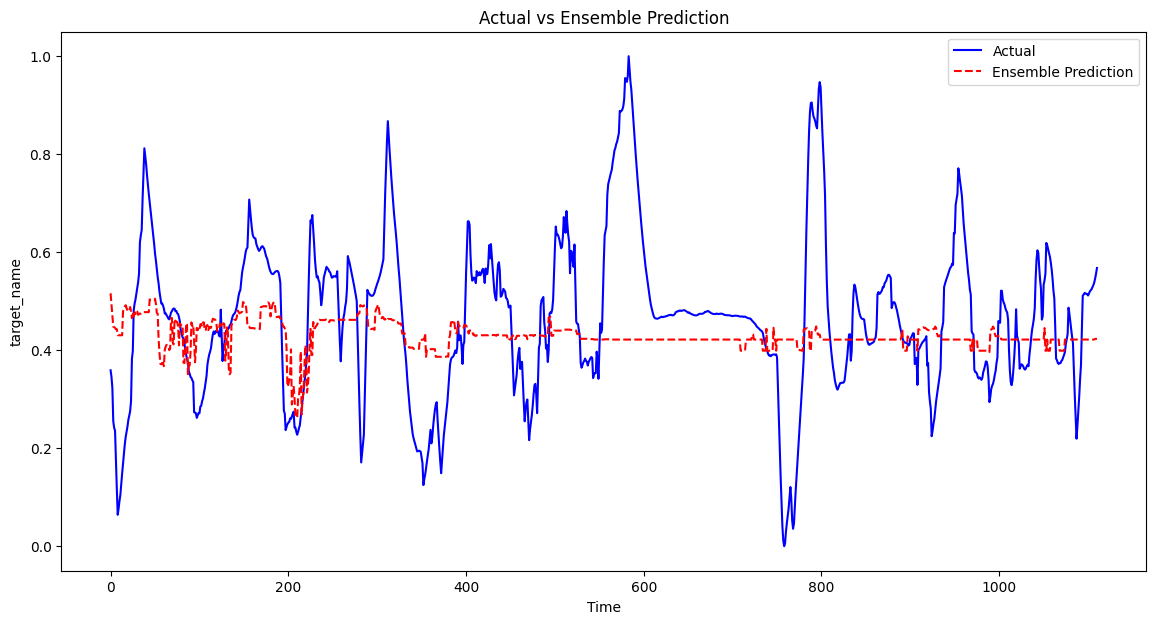

In [33]:
rf_model1 = RandomForestRegressor(n_estimators=80, random_state=42)
rf_model2 = RandomForestRegressor(n_estimators=90, random_state=42)
svr_model = SVR(kernel='rbf')

ensemble_model = Ensemble([rf_model1, rf_model2, svr_model])
ensemble_model.fit(X_train, y_train)

plot_ensemble_predictions(ensemble_model, X_test, y_test, 'target_name')

Using two random forest regressors and 1 SVR yields a poor fit.

# Test Case 5: Ensemble with Three Different Models

Ensemble Model MSE: 0.02334128185154848


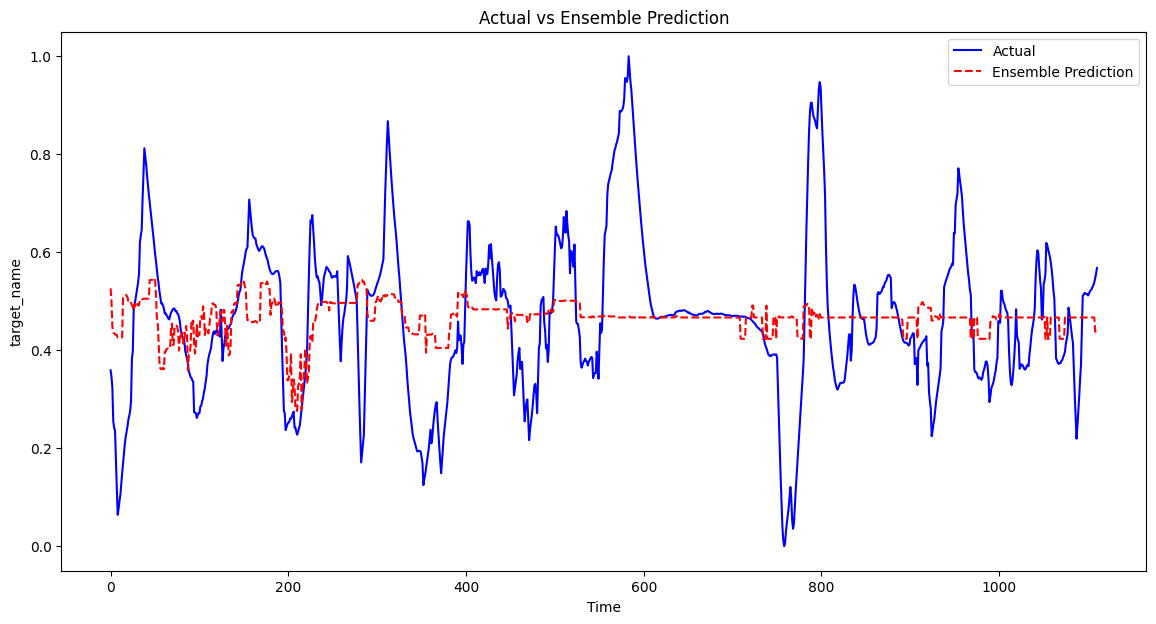

In [34]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
svr_model = SVR(kernel='rbf')

ensemble_model = Ensemble([rf_model, gb_model, svr_model])
ensemble_model.fit(X_train, y_train)

plot_ensemble_predictions(ensemble_model, X_test, y_test, 'target_name')

# Conclusions

Bagging and boosting algorithms show the best fits, when ensembling multiple (3, as we found out for this particular use case) models. By adapting the number of estimators, it is possible to obtain one with a very low quantity, which will prevent the ensemble with fitting to noise, another one with an appropriate quantity of estimators, and lastly, one last model with a higher number of estimators. The last two, combined, can guarantee a quality fit
